# Generating Recommendations with Collaborative filtering 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats.stats import pearsonr  

## Recommendations Data

We are going to use set of users who have given ratings to the movies of their choice. The following is a dict object containg the different users as keys and their values are a dictionary of movies with each movie's value being the rating given by the user

In [2]:
movie_user_preferences={'Jill': {'Avenger: Age of Ultron': 7.0,
  'Django Unchained': 6.5,
  'Gone Girl': 9.0,
  'Kill the Messenger': 8.0},
 'Julia': {'Avenger: Age of Ultron': 10.0,
  'Django Unchained': 6.0,
  'Gone Girl': 6.5,
  'Kill the Messenger': 6.0,
  'Zoolander': 6.5},
 'Max': {'Avenger: Age of Ultron': 7.0,
  'Django Unchained': 7.0,
  'Gone Girl': 10.0,
  'Horrible Bosses 2': 6.0,
  'Kill the Messenger': 5.0,
  'Zoolander': 10.0},
 'Robert': {'Avenger: Age of Ultron': 8.0,
  'Django Unchained': 7.0,
  'Horrible Bosses 2': 5.0,
  'Kill the Messenger': 9.0,
  'Zoolander': 9.0},
 'Sam': {'Avenger: Age of Ultron': 10.0,
  'Django Unchained': 7.5,
  'Gone Girl': 6.0,
  'Horrible Bosses 2': 3.0,
  'Kill the Messenger': 5.5,
  'Zoolander': 7.0},
 'Toby': {'Avenger: Age of Ultron': 8.5,
  'Django Unchained': 9.0,
  'Zoolander': 2.0},
 'William': {'Avenger: Age of Ultron': 6.0,
  'Django Unchained': 8.0,
  'Gone Girl': 7.0,
  'Horrible Bosses 2': 4.0,
  'Kill the Messenger': 6.5,
  'Zoolander': 4.0}}

movie_user_preferences['William']['Gone Girl']

7.0

## User Based Collaborative Fitlering

Lets start to build a user based collaborative filtering by finding users who are similar to each other

### Finding similar users

When you have the data about what people like, you need a way to determine the similarity between the different users. The similarity between the different users is determined by comparing each user with every other user and computing a similarity score. This similarity score can be computed using the Pearson correlation, Euclidean Distance, Manhattan Distance etc. 

#### Euclidean Distance Score

Euclidean distance is the minimum distance between two points in space. Let's try to understand this by plotting the users who have watched Gone Girl and Avengers

In [3]:
data = []
for i in movie_user_preferences.keys():
    try:
        data.append( (i
        ,movie_user_preferences[i]['Django Unchained']
        ,movie_user_preferences[i]['Avenger: Age of Ultron']) )
    except:
        pass
        
    
df = pd.DataFrame(data = data, columns = ['user', 'django', 'avenger'])
df

,user,django,avenger
0,William,8.0,6.0
1,Robert,7.0,8.0
2,Jill,6.5,7.0
3,Max,7.0,7.0
4,Sam,7.5,10.0
5,Julia,6.0,10.0
6,Toby,9.0,8.5


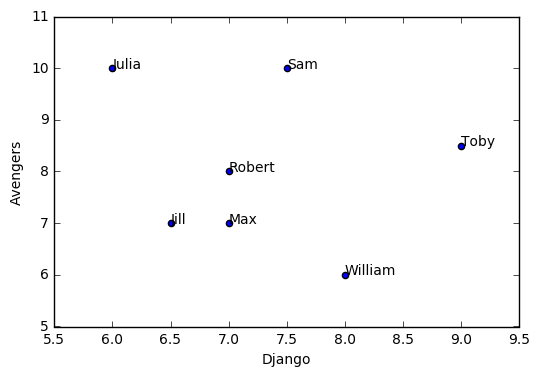

In [4]:
plt.scatter(df.django, df.avenger)
plt.xlabel('Django')
plt.ylabel('Avengers')
for i,txt in enumerate(df.user):
    plt.annotate(txt, (df.django[i],df.avenger[i]))
plt.show()

We can see that Jill and Toby are quite far from each other where as Robert and Max are quite close to each other. Let's compute the Euclidean distance between each other.

In [5]:
#Euclidean distance between Jill and Toby
sqrt(pow(8-7,2)+pow(9-6,2))

3.1622776601683795

In [6]:
#Euclidean distance between Robert and Max
sqrt(pow(8-7,2)+pow(7-7,2))

1.0

We can see that the further the user are away from each other, the euclidean distance is higher. We'll convert the euclidean distance to show that the higher values indicate more similarity. This can be done by inverting the euclidean distance and also adding one so that there is no divide by zero

In [7]:
#Similarity Score based on Euclidean distance between Jill and Toby
1/(1 + sqrt(pow(8-7,2)+pow(9-6,2)) )

0.2402530733520421

In [8]:
#Similarity Score based on Euclidean distance between Robert and Max
1/(1 + sqrt(pow(8-7,2)+pow(7-7,2)) )

0.5

Let's create a function that calcuates the similarity score between two users

In [9]:
# Returns a distance-based similarity score for person1 and person2
def sim_distance(prefs,person1,person2):
    # Get the list of shared_items
    si={}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item]=1
            
    # if they have no ratings in common, return 0
    if len(si)==0: return 0
    
    # Add up the squares of all the differences
    sum_of_squares=sum([pow(prefs[person1][item]-prefs[person2][item],2)
    for item in prefs[person1] if item in prefs[person2]])
    
    return 1/(1+sum_of_squares)

Let's apply the above function to calculate the similarity score between Sam and Toby

In [10]:
sim_distance(movie_user_preferences,'Sam','Toby')

0.03278688524590164

#### Pearson Correlation Score

We have already studied what is peasron correlation in chapter 2. We'll use pearson correlation to compute the similiarity score between two users.

Lets see how Sam and Toby are correlated to each other

In [11]:
def create_movie_user_df(input_data, user1, user2):
    data = []
    for movie in input_data[user1].keys():
        if movie in input_data[user2].keys():
            try:
                data.append( (movie
                ,input_data[user1][movie]
                ,input_data[user2][movie]) )
            except:
                pass
            
        
    return pd.DataFrame(data = data, columns = ['movie', user1, user2])

df = create_movie_user_df(movie_user_preferences, 'Sam', 'William')
df

,movie,Sam,William
0,Django Unchained,7.5,8.0
1,Zoolander,7.0,4.0
2,Kill the Messenger,5.5,6.5
3,Avenger: Age of Ultron,10.0,6.0
4,Horrible Bosses 2,3.0,4.0
5,Gone Girl,6.0,7.0


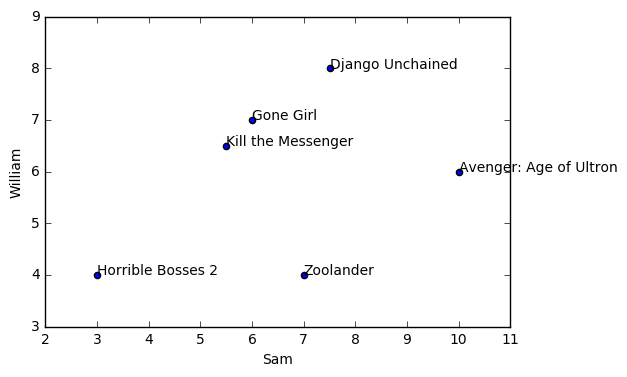

In [12]:
plt.scatter(df.Sam, df.William)
plt.xlabel('Sam')
plt.ylabel('William')
for i,txt in enumerate(df.movie):
    plt.annotate(txt, (df.Sam[i],df.William[i]))
plt.show()

Let's compute the pearson correlation between Sam and William

In [13]:
pearsonr(df.Sam,df.William)

(0.37067401970178421, 0.46945413268410918)

Let's see the scatter plot between 

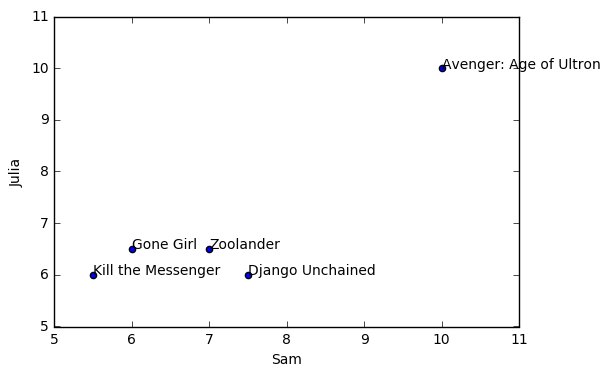

In [14]:
df = create_movie_user_df(movie_user_preferences, 'Sam', 'Julia')
df

plt.scatter(df.Sam, df.Julia)
plt.xlabel('Sam')
plt.ylabel('Julia')
for i,txt in enumerate(df.movie):
    plt.annotate(txt, (df.Sam[i],df.Julia[i]))
plt.show()

Let's compute the pearson correlation Sam and Julia

In [15]:
pearsonr(df.Sam,df.Julia)

(0.88285183326025085, 0.047277507003439599)

We can see that Sam and Julia are very similar to each other

In [16]:
# Returns the Pearson correlation coefficient for p1 and p2
def sim_pearson(prefs,p1,p2):
    # Get the list of mutually rated items
    si={}
    for item in prefs[p1]:
        if item in prefs[p2]: si[item]=1
            
    # Find the number of elements
    n=len(si)
    
    # if they are no ratings in common, return 0
    if n==0: return 0
    
    # Add up all the preferences
    sum1=sum([prefs[p1][it] for it in si])
    sum2=sum([prefs[p2][it] for it in si])
    
    # Sum up the squares
    sum1Sq=sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq=sum([pow(prefs[p2][it],2) for it in si])
    
    # Sum up the products
    pSum=sum([prefs[p1][it]*prefs[p2][it] for it in si])
    
    # Calculate Pearson score
    num=pSum-(sum1*sum2/n)
    den=sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2,2)/n))
    if den==0: return 0
    
    r=num/den
    
    return r


Let's compute the pearson correlation between Sam and Julia using the above function and verify if its computing correctly

In [17]:
sim_pearson(movie_user_preferences,'Sam','Julia')

0.8828518332602507

### Ranking the users

Once we have the methods of computing the similarity between the users, we then proceed to the rank the users based on the similarity between a particular user. I would like to know who are the people who are most similar to me. We can achieve this with the following code 

In [18]:
def topMatches(prefs,person,n=5,similarity=sim_pearson):
    scores=[(similarity(prefs,person,other),other)
        for other in prefs if other!=person]
    
    # Sort the list so the highest scores appear at the top
    scores.sort( )
    scores.reverse( )
    return scores[0:n]

Let's see who are top 3 people who are similar to Sam

In [19]:
topMatches(movie_user_preferences,'Toby', n = 3, similarity = sim_distance)

[(0.10526315789473684, 'Jill'),
 (0.08163265306122448, 'William'),
 (0.03278688524590164, 'Sam')]

### Recommending Items

Once you know who are similar to you, you would now like to know which are the movies that should be recommended. The following shows how to compute a score for the movies so that we can know which is the most recommended movie

<img src="files/images/similiarity.png">

We multiply the similiarity score of with the movie ratings of each of the user. We then sum this new score and then divide with the applicable similiarity score. In summary, we are taking weighted average based on the similiarity score.

From the above, we can see that Gone Girl has a very good score to be recommended and then followed by Kill the Messenger

We'll now create a function which will generate recommendations for a user by encompassing the above logic

In [20]:
# Gets recommendations for a person by using a weighted average
# of every other user's rankings
def getRecommendations(prefs,person,similarity=sim_pearson):
    totals={}
    simSums={}
    for other in prefs:
        # don't compare me to myself
        if other==person: continue
        sim=similarity(prefs,person,other)
        
        # ignore scores of zero or lower
        if sim<=0: continue
        for item in prefs[other]:
            
            # only score movies I haven't seen yet
            if item not in prefs[person] or prefs[person][item]==0:
                # Similarity * Score
                totals.setdefault(item,0)
                totals[item]+=prefs[other][item]*sim
                # Sum of similarities
                simSums.setdefault(item,0)
                simSums[item]+=sim
                
    # Create the normalized list
    rankings=[(total/simSums[item],item) for item,total in totals.items( )]
    
    # Return the sorted list
    rankings.sort( )
    rankings.reverse( )
    return rankings

Let's get the recommendation using the above function

In [21]:
getRecommendations(movie_user_preferences,'Toby')

[(6.587965809121003, 'Gone Girl'),
 (6.087965809121002, 'Kill the Messenger'),
 (3.608127720528246, 'Horrible Bosses 2')]

In [22]:
getRecommendations(movie_user_preferences,'Toby', similarity = sim_distance)

[(7.773043918833567, 'Gone Girl'),
 (6.976295282563891, 'Kill the Messenger'),
 (4.093380589669568, 'Horrible Bosses 2')]

We now have created a User based collaborative filtering

## Item Based Collaborative Filtering

User based collaborative filtering finds the similiarity between users and then using the items in among the similar user, recommendation is made. 

Item based collaborative filtering finds the similiarity between the items. This is then used to find the new recommendations for a user

To begin with the Item based collaborative filtering, we'll first have to invert our dataset by putting the movies as the 1st layer followed by the users as the 2nd layer

In [23]:
def transformPrefs(prefs):
    result={}
    for person in prefs:
        for item in prefs[person]:
            result.setdefault(item,{})
            
            # Flip item and person
            result[item][person]=prefs[person][item]
    return result

transformPrefs(movie_user_preferences)

{'Avenger: Age of Ultron': {'Jill': 7.0,
  'Julia': 10.0,
  'Max': 7.0,
  'Robert': 8.0,
  'Sam': 10.0,
  'Toby': 8.5,
  'William': 6.0},
 'Django Unchained': {'Jill': 6.5,
  'Julia': 6.0,
  'Max': 7.0,
  'Robert': 7.0,
  'Sam': 7.5,
  'Toby': 9.0,
  'William': 8.0},
 'Gone Girl': {'Jill': 9.0,
  'Julia': 6.5,
  'Max': 10.0,
  'Sam': 6.0,
  'William': 7.0},
 'Horrible Bosses 2': {'Max': 6.0, 'Robert': 5.0, 'Sam': 3.0, 'William': 4.0},
 'Kill the Messenger': {'Jill': 8.0,
  'Julia': 6.0,
  'Max': 5.0,
  'Robert': 9.0,
  'Sam': 5.5,
  'William': 6.5},
 'Zoolander': {'Julia': 6.5,
  'Max': 10.0,
  'Robert': 9.0,
  'Sam': 7.0,
  'Toby': 2.0,
  'William': 4.0}}

Now we would like to find the similar movies for each of the movies

In [27]:
def calculateSimilarItems(prefs,n=10):
    # Create a dictionary of items showing which other items they
    # are most similar to.
    result={}
    
    # Invert the preference matrix to be item-centric
    itemPrefs=transformPrefs(prefs)
    c=0
    for item in itemPrefs:
        # Status updates for large datasets
        c+=1
        if c%100==0: print("%d / %d" % (c,len(itemPrefs)))
        # Find the most similar items to this one
        scores=topMatches(itemPrefs,item,n=n,similarity=sim_distance)
        result[item]=scores
    return result

itemsim=calculateSimilarItems(movie_user_preferences)
itemsim

{'Avenger: Age of Ultron': [(0.034782608695652174, 'Django Unchained'),
  (0.023121387283236993, 'Gone Girl'),
  (0.022988505747126436, 'Kill the Messenger'),
  (0.015625, 'Horrible Bosses 2'),
  (0.012738853503184714, 'Zoolander')],
 'Django Unchained': [(0.05714285714285714, 'Kill the Messenger'),
  (0.05063291139240506, 'Gone Girl'),
  (0.034782608695652174, 'Avenger: Age of Ultron'),
  (0.023668639053254437, 'Horrible Bosses 2'),
  (0.012578616352201259, 'Zoolander')],
 'Gone Girl': [(0.09090909090909091, 'Zoolander'),
  (0.05063291139240506, 'Django Unchained'),
  (0.036036036036036036, 'Kill the Messenger'),
  (0.02857142857142857, 'Horrible Bosses 2'),
  (0.023121387283236993, 'Avenger: Age of Ultron')],
 'Horrible Bosses 2': [(0.03278688524590164, 'Kill the Messenger'),
  (0.02857142857142857, 'Gone Girl'),
  (0.023668639053254437, 'Django Unchained'),
  (0.02040816326530612, 'Zoolander'),
  (0.015625, 'Avenger: Age of Ultron')],
 'Kill the Messenger': [(0.05714285714285714, 'D

Once we have the similiarity between all the movies. We would like to generate the recommendations for a user. 

The table below shows the movies seen by Toby under the Movie column and the rating given by Toby. The movie columns are the similiarity of the movie with the ones seen by Toby. The columns with R as a prefix is the product of the Rating and similiarity score. 

Finally we normalize the values by summing the R prefixed column then divided by the sum of the similiarity score of the movie column.

The Table below shows Kill The Messenger is the most recommended movie.

<img src="files/images/similiarity2.png">

We would now like to generate the recommendations by encompassing the above logic

In [28]:
def getRecommendedItems(prefs,itemMatch,user):
    userRatings=prefs[user]
    scores={}
    totalSim={}
    
    # Loop over items rated by this user
    for (item,rating) in userRatings.items( ):
        
        # Loop over items similar to this one
        for (similarity,item2) in itemMatch[item]:
            
            # Ignore if this user has already rated this item
            if item2 in userRatings: continue
                
            # Weighted sum of rating times similarity
            scores.setdefault(item2,0)
            scores[item2]+=similarity*rating
            
            # Sum of all the similarities
            totalSim.setdefault(item2,0)
            totalSim[item2]+=similarity
            
    # Divide each total score by total weighting to get an average
    rankings=[(score/totalSim[item],item) for item,score in scores.items( )]
    
    # Return the rankings from highest to lowest
    rankings.sort( )
    rankings.reverse( )
    return rankings

Let's generate recommendations for Toby using the Item Based Recommender

In [29]:
getRecommendedItems(movie_user_preferences, itemsim,'Toby')

[(7.044841200971884, 'Kill the Messenger'),
 (6.476296577225752, 'Horrible Bosses 2'),
 (5.0651585538275095, 'Gone Girl')]